In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import math
from scipy.optimize import minimize
import warnings

# Suppress all warnings including type errors
warnings.filterwarnings('ignore')

# Configure numpy to handle errors gracefully
np.seterr(all='ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Project - Libraries Loaded Successfully")
print("=" * 60)
print("Note: Error handling enabled - code will continue running even with incomplete implementations")

Project - Libraries Loaded Successfully
Note: Error handling enabled - code will continue running even with incomplete implementations


# GARCH(1,1) Volatility Estimation Project

## Objective
This project implements Maximum Likelihood Estimation (MLE) for the GARCH(1,1) model to estimate and forecast volatility using S&P 500 daily returns. You will learn to:

- Fit GARCH(1,1) parameters using real market data
- Implement volatility forecasting models
- Analyze volatility clustering and mean reversion
- Create volatility term structure forecasts

## Project Overview
We will use S&P 500 daily closing prices from July 18, 2005 to August 13, 2010 to estimate GARCH parameters, then forecast future volatility patterns.

## Data Collection

**Dataset**: S&P 500 daily closing prices  
**Period**: July 18, 2005 to August 13, 2010  
**Source**: Yahoo Finance (^GSPC)  
**Rationale**: This period includes the 2008 financial crisis, providing rich volatility dynamics for GARCH modeling.

In [2]:
import yfinance as yf

# Download SP500 daily close prices from 2005-07-18 to 2010-08-13
sp500 = yf.download('^GSPC', start='2005-07-18', end='2010-08-14')
sp500_close = sp500['Close']
sp500_close = sp500_close.dropna()  # Remove any NaN values
display(sp500_close.head())
display(sp500_close.tail())

[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2005-07-18,1221.130005
2005-07-19,1229.349976
2005-07-20,1235.199951
2005-07-21,1227.040039
2005-07-22,1233.680054


Ticker,^GSPC
Date,
2010-08-09,1127.790039
2010-08-10,1121.060059
2010-08-11,1089.469971
2010-08-12,1083.609985
2010-08-13,1079.250000


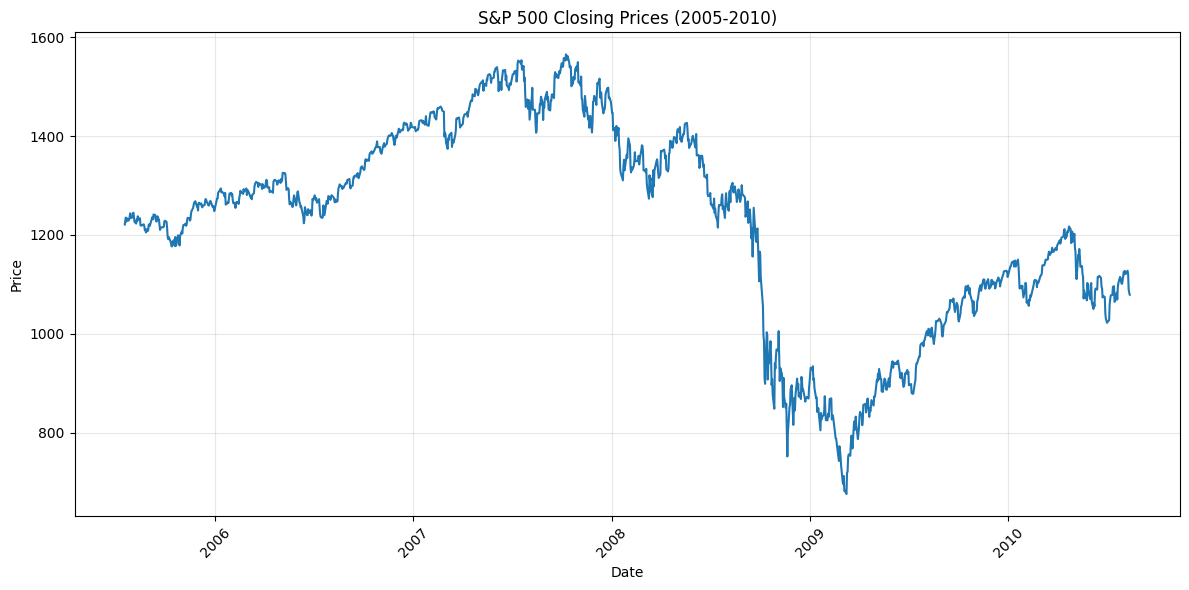

In [3]:
S = sp500_close.to_numpy()
S = S.flatten()  # Ensure S is 1D

# Plot the closing prices
# Create date labels for x-axis
dates = sp500_close.index
plt.figure(figsize=(12, 6))
plt.plot(dates, S)
plt.title('S&P 500 Closing Prices (2005-2010)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Theoretical Background

### GARCH(1,1) Model
The GARCH(1,1) model captures volatility clustering by modeling conditional variance as:

$$\sigma_n^2 = \omega + \alpha_1 u_{n-1}^2 + \beta_1 \sigma_{n-1}^2$$

where:
- $\sigma_n^2$: Conditional variance at time $n$
- $\omega$: Long-term variance component ($\omega = \gamma V_L$)
- $\alpha_1$: ARCH coefficient (impact of recent shocks)
- $\beta_1$: GARCH coefficient (persistence of volatility)
- $u_n$: Return innovation at time $n$
- Constraint: $\alpha_1 + \beta_1 < 1$ for stationarity

### Maximum Likelihood Estimation Algorithm

1. **Initialize Parameters**: Set starting values for $(\omega, \alpha_1, \beta_1)$
2. **Calculate Returns**: Compute log returns $u_i = \frac{S_i - S_{i-1}}{S_{i-1}}$
3. **Update Variance**: For $i = 2, \ldots, n$:
   $$\sigma_i^2 = \omega + \alpha_1 u_{i-1}^2 + \beta_1 \sigma_{i-1}^2$$
4. **Likelihood Function**: Maximize the log-likelihood:
   $$\ell(\omega, \alpha_1, \beta_1) = -\sum_{i=2}^{n} \left[\log(\sigma_i^2) + \frac{u_i^2}{\sigma_i^2}\right]$$
5. **Optimization**: Use numerical methods (e.g., `scipy.optimize.minimize`) to find optimal parameters

## Task 1: GARCH(1,1) Parameter Estimation

### Requirements:
1. **Parameter Estimation**: Implement MLE to estimate $(\omega, \alpha_1, \beta_1)$ using S&P 500 returns
2. **Long-term Volatility**: Calculate the unconditional volatility: $\sigma_L = \sqrt{\frac{\omega}{1 - \alpha_1 - \beta_1}}$
3. **Model Fit Assessment**: Report the maximum log-likelihood value
4. **Volatility Visualization**: Plot the estimated conditional volatility time series from 2005-07-18 to 2010-08-13


In [4]:
# Task 1 Solution
print("TASK 1 starts here ...")
print("=" * 50)

TASK 1 starts here ...


GARCH(1,1) MLE Results
omega  = 0.000001424516
Estimated alpha = 0.079474
Estimated beta  = 0.908071
Estimated sigma = 0.010695
Max log-likelihood = 10229.698847


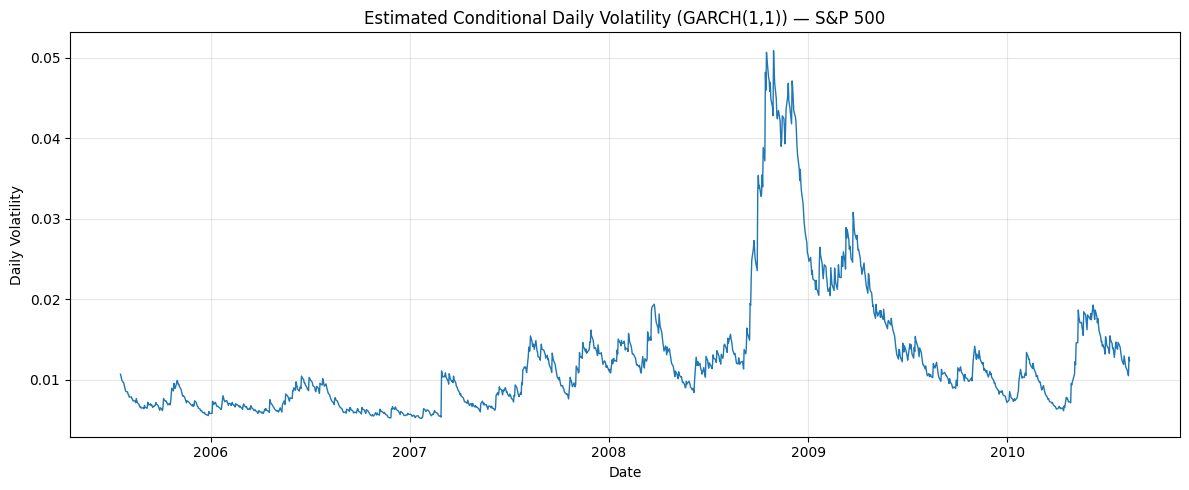

In [5]:
# Calculate Daily Returns
u_series = sp500_close.pct_change().dropna()
u = u_series.to_numpy().flatten()
u_dates = u_series.index

# GARCH(1,1) Function
def garch(omega, alpha, beta, u):
    n = len(u)
    var = np.zeros(n)
    var[0] = max(1e-12, omega / max(1e-6, 1.0 - alpha - beta))
    for t in range(1, n):
        var[t] = omega + alpha * (u[t-1]**2) + beta * var[t-1]
    return np.clip(var, 1e-12, None)

# Maximum Likelihood Estimation Algorithm
def loglike(x, u):
    omega, alpha, beta = x
    var = garch(omega, alpha, beta, u)
    return float(np.sum(np.log(var) + (u**2)/var))

# Initial Guess
alpha0, beta0 = 0.01, 0.95
omega0 = max(1e-12, (1 - alpha0 - beta0) * np.var(u, ddof=1))
x0 = np.array([omega0, alpha0, beta0])

# Optimization
res = minimize(
    fun=loglike,
    x0=x0,
    args=(u,),
    method='trust-constr',
    bounds=[(1e-12, None), (0.0, 0.999999), (0.0, 0.999999)],
    constraints=[{
        'type': 'ineq',
        'fun': lambda x: 0.999999 - x[1] - x[2]
    }],
)

omega_hat, alpha_hat, beta_hat = res.x
max_loglike = -res.fun
sigma_L = np.sqrt(omega_hat / (1.0 - alpha_hat - beta_hat))

# MLE Results
print("GARCH(1,1) MLE Results")
print(f"omega  = {omega_hat:.12f}")
print(f"Estimated alpha = {alpha_hat:.6f}")
print(f"Estimated beta  = {beta_hat:.6f}")
print(f"Estimated sigma = {sigma_L:.6f}")
print(f"Max log-likelihood = {max_loglike:.6f}")

# Visualization
var_hat = garch(omega_hat, alpha_hat, beta_hat, u)
sigma_hat = np.sqrt(np.clip(var_hat, 1e-12, None))

plt.figure(figsize=(12, 5))
plt.plot(u_dates, sigma_hat, lw=1)
plt.title('Estimated Conditional Daily Volatility (GARCH(1,1)) — S&P 500')
plt.xlabel('Date'); plt.ylabel('Daily Volatility')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Task 2: Volatility Forecasting and Term Structure

### Part A: Out-of-Sample Forecasting
Using the fitted GARCH(1,1) model from Task 1:

1. **Forecast Period**: Generate daily volatility forecasts from 2010-08-14 to 2015-08-08
2. **Forecast Formula**: For $h$-day ahead forecast:
   $$\sigma_{n+h}^2 = V_L + (\alpha_1 + \beta_1)^h (\sigma_n^2 - V_L)$$
3. **Visualization**: Plot the forecasted volatility time series

### Part B: Volatility Term Structure
Calculate annualized volatility forecasts for multiple horizons:

1. **Forecast Horizons**: 10, 30, 50, 100, 500 trading days
2. **Annualization**: Convert daily volatility to annual using $\sigma_{annual} = \sigma_{daily} \times \sqrt{252}$
3. **Term Structure Plot**: Create a volatility term structure curve showing how volatility expectations change with forecast horizon


In [6]:
# Task 2 Solution
print("TASK 2 starts here ...")
print("=" * 50)

TASK 2 starts here ...


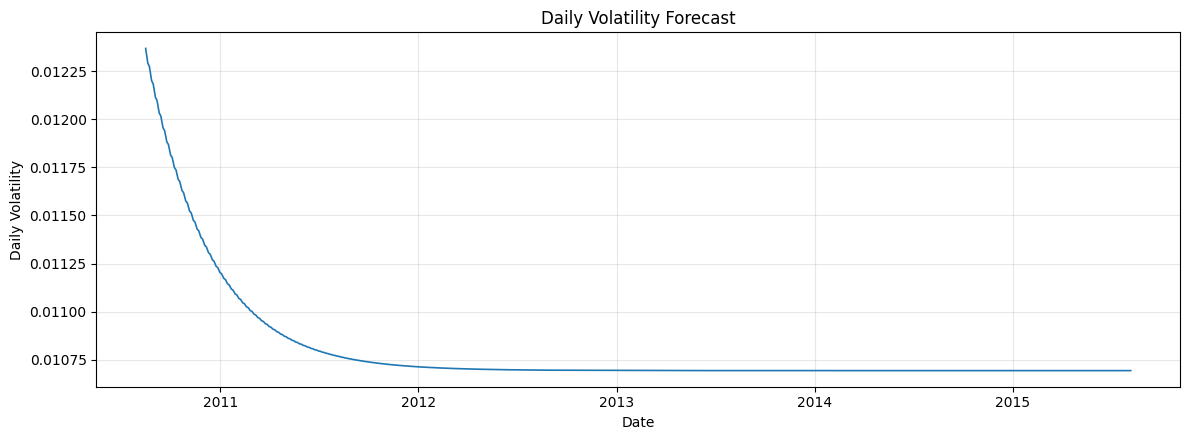

In [7]:
# Part A

start_date = pd.Timestamp("2010-08-14")
end_date   = pd.Timestamp("2015-08-08")
forecast_dates = pd.bdate_range(start=start_date, end=end_date)
H = forecast_dates.shape[0]

# Long-Run Variance
V_L = omega_hat / (1.0 - alpha_hat - beta_hat)

# sigma_n^2 on the last trainingsample date (2010-08-13)
sigma_n2 = var_hat[-1]

# Daily Volatility Forecasts
h = np.arange(1, H + 1, dtype=float)
sigma2_forecast = V_L + np.power(alpha_hat + beta_hat, h) * (sigma_n2 - V_L)
sigma_forecast  = np.sqrt(np.clip(sigma2_forecast, 1e-12, None))

# Visualization
plt.figure(figsize=(12, 4.5))
if H > 0:
    plt.plot(forecast_dates, sigma_forecast, lw=1.2)
plt.title('Daily Volatility Forecast')
plt.xlabel('Date'); plt.ylabel('Daily Volatility')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


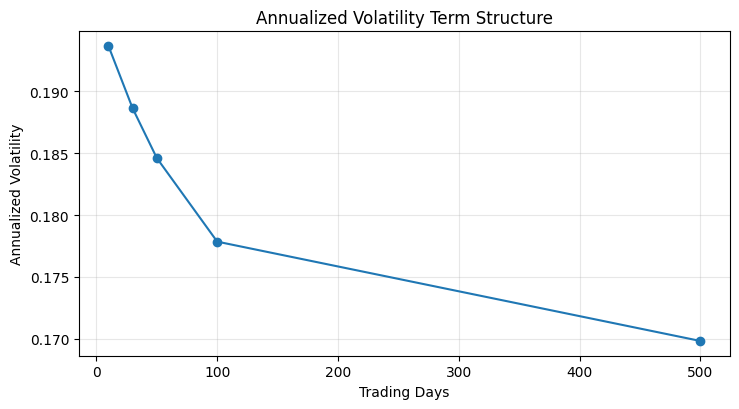

In [8]:
# Part B

# Forecast horizons
horizons = np.array([10, 30, 50, 100, 500], dtype=float)

# Annual Volatility Horizon Forecasts
sigma2_horizons = V_L + np.power(alpha_hat + beta_hat, horizons) * (sigma_n2 - V_L)
sigma_horizons = np.sqrt(np.clip(sigma2_horizons, 1e-12, None))
sigma_annual_horizons = sigma_horizons * np.sqrt(252.0)

# Visualization
plt.figure(figsize=(7.5, 4.2))
plt.plot(horizons, sigma_annual_horizons, marker='o')
plt.title('Annualized Volatility Term Structure')
plt.xlabel('Trading Days')
plt.ylabel('Annualized Volatility')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
